### Gaussian propagation
Based on the practitioners guide, we first simulate a focussed gaussian field in the Crank-Nicolson scheme, the fourier scheme and the analytical solution for quanitfying the accuracies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Crank-Nicolson
Practitioners guide page 41.

In [2]:
# all units in mm
omega_0 = 0.01 # beam waist
lamb = 1030e-6 # wavelength
f = 0.2 # focal length of lense
n0 = 1.5 # refrective index
k0 = n0 * 2 * np.pi / lamb

# radia grid parameters
N_perpendicular = 1024 # number of inner gid points in r direction (+2 boundry points)
r_max = 0.2 # domain radius
r_min = 0#1e-9 # may be > 0 for stability?
Delta_r = (r_max - r_min)/N_perpendicular
r = np.linspace(r_min, r_max, N_perpendicular+1, dtype=np.clongdouble)

# propagation grid parameters
z_0 = 0
z_max = 0.4 # mm
N_z = 1023*4
Delta_z = (z_max - z_0)/N_z
z = np.linspace(z_0, z_max, N_z + 1)


In [3]:
def generate_Delta_j(N, nu = 1):
    # nu = 1 for radial coordinates, nu = 0 for euclidean
    matrix = np.zeros([N+1, N+1])
    for j in range(1, N): #do not set the first and last row since they be overwritten by boundry conditions
        
        
        u_j = 1 - nu/(2*j)
        v_j = 1 + nu/(2*j)
        
        matrix[j, j] = -2
        matrix[j, j-1] = u_j
        matrix[j, j+1] = v_j
    return matrix

In [4]:
# calculate L matrices
Delta_j = generate_Delta_j(N_perpendicular)
delta = Delta_z /(4 * k0 * Delta_r**2)
L_plus = np.identity(N_perpendicular+1) + (1j*delta*Delta_j)
L_minus = np.identity(N_perpendicular+1) - (1j*delta*Delta_j)

In [5]:
# boundary conditions
def apply_boundry_to_L_matrices(L_plus, L_minus, nu=1):
    
    L_plus[0,0] = 1 - (4 * 1j * delta)
    L_plus[0,1] = (4 * 1j * delta)

    L_minus[0,0] =  1 + (4 * 1j * delta)
    L_minus[0,1] =  (-4 * 1j * delta)
    L_minus[-1,-1] = 1
    return L_plus, L_minus

L_plus, L_minus = apply_boundry_to_L_matrices(L_plus, L_minus)


In [6]:
L_minus_inv = np.linalg.inv(L_minus)
L = np.matmul(L_minus_inv, L_plus)

In [7]:
### initial condition
E_0 = 1
E_init = E_0 * np.exp(-r**2 / omega_0**2 - 1j * k0 * r**2 / (2*f))

if False:
    plt.plot(r, np.abs(E_init)**2)
    plt.axis([0,0.2,0,1])
    plt.show()

In [8]:
E_final = np.zeros([N_perpendicular+1, N_z], dtype=np.clongdouble)
E_final[:,0] = E_init

for n in range(1, N_z):
    E_final[:,n] = np.dot(L, E_final[:,n-1])

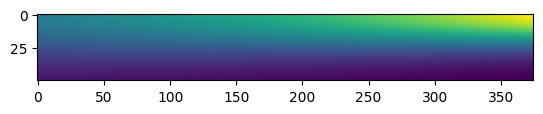

In [9]:
I_final = np.abs(E_final)**2
plt.imshow(I_final[:50,:750:2])


### Analytical solution
Page 39 in practitioners guide

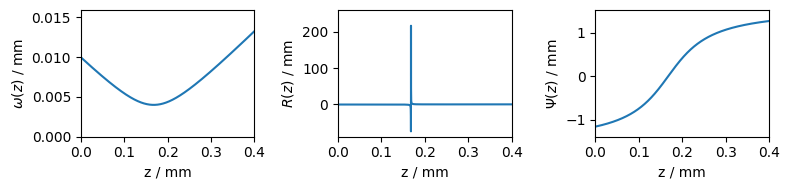

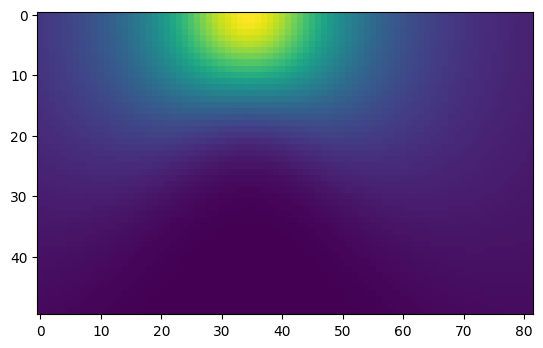

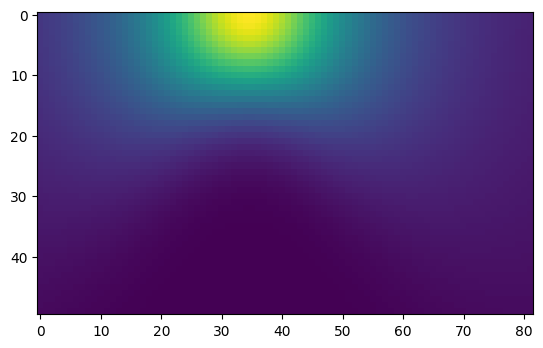

In [10]:
def analytical_w(z):
    a = (1-z/f)**2
    z_R = k0*omega_0**2/2
    b = z**2/z_R**2
    return omega_0*(a + b)**0.5

def analytical_R(z):
    z_R = k0*omega_0**2/2
    df = f/(1+f**2/z_R**2)
    return z-df + (df * (f - df)) / (z - df)

def analytical_Psi(z):
    z_R = k0*omega_0**2/2
    df = f/(1+f**2/z_R**2)
    return np.arctan((z-df) / (f*df-df**2)**0.5)

fig, axarr = plt.subplots(1,3, figsize=[8,2])
axarr[0].plot(z, analytical_w(z))
axarr[0].axis([z_0, z_max, r_min, analytical_w(z).max()*1.2])
axarr[0].set_xlabel('z / mm')
axarr[0].set_ylabel(r'$\omega(z)$ / mm')

axarr[1].plot(z, analytical_R(z))
axarr[1].axis([z_0, z_max, analytical_R(z).min()*1.2, analytical_R(z).max()*1.2])
axarr[1].set_xlabel('z / mm')
axarr[1].set_ylabel(r'$R(z)$ / mm')

axarr[2].plot(z, analytical_Psi(z))
axarr[2].axis([z_0, z_max, analytical_Psi(z).min()*1.2, analytical_Psi(z).max()*1.2])
axarr[2].set_xlabel('z / mm')
axarr[2].set_ylabel(r'$\Psi(z)$ / mm')


plt.tight_layout()
plt.show()

def analytical_E(r,z):
    a = E_0* omega_0 / analytical_w(z)
    b = r**2 / analytical_w(z)**2
    c = 1j * k0 * r**2 / (2 * analytical_R(z))
    d = 1j * analytical_Psi(z)

    return a * np.exp(-b +c -d)

E_analytical_final = analytical_E(*np.meshgrid(r,z)).T
I_analytical_final = np.abs(E_analytical_final)**2
plt.imshow(I_analytical_final[:50,::50])
plt.show()

plt.imshow(I_final[:50,::50])
plt.show()

max error: 0.3 percent


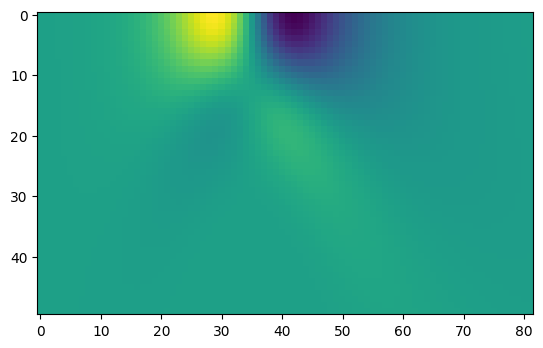

In [11]:
difference = I_analytical_final[:50,::50] -  I_final[:50,::50] 
print('max error: %.1f percent'%(np.max(difference) / I_analytical_final[:50,::50].max() * 100))
plt.imshow(difference)
plt.show()